In [1]:
import torch
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

# CIFAR-10データセットの読み込み

In [2]:
from datasets import load_dataset
# datasetをロード (初回の読み込みだけやや時間かかる)
cifar10 = load_dataset("cifar10")

Found cached dataset parquet (/root/.cache/huggingface/datasets/parquet/plain_text-d4c080360fb556b0/0.0.0/14a00e99c0d15a23649d0db8944380ac81082d4b021f398733dd84f3a6c569a7)


  0%|          | 0/2 [00:00<?, ?it/s]

In [3]:
cifar10

DatasetDict({
    train: Dataset({
        features: ['img', 'label'],
        num_rows: 50000
    })
    test: Dataset({
        features: ['img', 'label'],
        num_rows: 10000
    })
})

In [3]:
# 訓練セットだけ取り出す
train_ds = cifar10["train"]
train_ds

Dataset({
    features: ['img', 'label'],
    num_rows: 50000
})

In [4]:
len(train_ds)

50000

In [5]:
train_ds[0]

{'img': <PIL.PngImagePlugin.PngImageFile image mode=RGB size=32x32>,
 'label': 0}

In [6]:
train_ds.column_names

['img', 'label']

In [7]:
print(train_ds.features)

{'img': Image(decode=True, id=None), 'label': ClassLabel(names=['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck'], id=None)}


In [8]:
print(train_ds[:5])

{'img': [<PIL.PngImagePlugin.PngImageFile image mode=RGB size=32x32 at 0x7FDA849C2BD0>, <PIL.PngImagePlugin.PngImageFile image mode=RGB size=32x32 at 0x7FDA849C2B10>, <PIL.PngImagePlugin.PngImageFile image mode=RGB size=32x32 at 0x7FDA849C2C10>, <PIL.PngImagePlugin.PngImageFile image mode=RGB size=32x32 at 0x7FDA849C2B90>, <PIL.PngImagePlugin.PngImageFile image mode=RGB size=32x32 at 0x7FDA849C2A50>], 'label': [0, 6, 0, 2, 7]}


In [9]:
import pandas as pd

cifar10.set_format("pandas")
df = cifar10["train"][:]
df.head()

,img,label
0,<PIL.PngImagePlugin.PngImageFile image mode=RG...,0
1,<PIL.PngImagePlugin.PngImageFile image mode=RG...,6
2,<PIL.PngImagePlugin.PngImageFile image mode=RG...,0
3,<PIL.PngImagePlugin.PngImageFile image mode=RG...,2
4,<PIL.PngImagePlugin.PngImageFile image mode=RG...,7


In [10]:
def label_int2str(row):
    return cifar10["train"].features["label"].int2str(row)

df["label_name"] = df["label"].apply(label_int2str)
df.head()

,img,label,label_name
0,<PIL.PngImagePlugin.PngImageFile image mode=RG...,0,airplane
1,<PIL.PngImagePlugin.PngImageFile image mode=RG...,6,frog
2,<PIL.PngImagePlugin.PngImageFile image mode=RG...,0,airplane
3,<PIL.PngImagePlugin.PngImageFile image mode=RG...,2,bird
4,<PIL.PngImagePlugin.PngImageFile image mode=RG...,7,horse


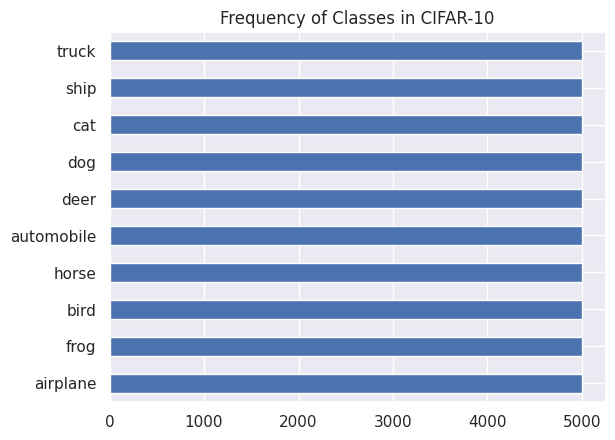

In [11]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme()

df["label_name"].value_counts(ascending=True).plot.barh()
plt.title("Frequency of Classes in CIFAR-10")
plt.show()

In [12]:
# pandas形式のデータセットをリセット
cifar10.reset_format()

# データセットの前処理
ViTで使われている前処理を適用する．

In [13]:
from transformers import ViTImageProcessor

# 今回は https://huggingface.co/google/vit-base-patch16-224-in21k を利用
model_name_or_path = 'google/vit-base-patch16-224-in21k'
processor = ViTImageProcessor.from_pretrained(model_name_or_path)
processor

2024-04-04 19:43:42.946936: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-04-04 19:43:44.206294: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2024-04-04 19:43:44.206423: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory
2024-04-04 19:43:44.206435: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Cannot dlopen some TensorRT libraries. If you would like to use Nv

ViTImageProcessor {
  "do_normalize": true,
  "do_rescale": true,
  "do_resize": true,
  "image_mean": [
    0.5,
    0.5,
    0.5
  ],
  "image_processor_type": "ViTImageProcessor",
  "image_std": [
    0.5,
    0.5,
    0.5
  ],
  "resample": 2,
  "rescale_factor": 0.00392156862745098,
  "size": {
    "height": 224,
    "width": 224
  }
}

In [14]:
# 前処理を5件のサンプルに適用してみる
processed_imgs = processor(images=train_ds[:5]["img"], return_tensors="pt")
processed_imgs["pixel_values"].shape # (batch, channel, height, width)になっている

torch.Size([5, 3, 224, 224])

In [15]:
processor.model_input_names # モデルがフォワードパスで期待するフィールド名

['pixel_values']

In [16]:
def transforms(batch):
    # 画像のバッチを変換してtorch.tensorにする
    inputs = processor(images=batch["img"], return_tensors="pt")

    # ラベルのフィールドも前処理時に追加
    inputs["labels"] = batch["label"]
    return inputs

In [17]:
transformed_ex = transforms(train_ds[:5])
print(transformed_ex)
print(transformed_ex["pixel_values"].size())
print(len(transformed_ex["labels"]))

{'pixel_values': tensor([[[[ 0.3961,  0.3961,  0.3961,  ...,  0.2941,  0.2941,  0.2941],
          [ 0.3961,  0.3961,  0.3961,  ...,  0.2941,  0.2941,  0.2941],
          [ 0.3961,  0.3961,  0.3961,  ...,  0.2941,  0.2941,  0.2941],
          ...,
          [-0.1922, -0.1922, -0.1922,  ..., -0.2863, -0.2863, -0.2863],
          [-0.1922, -0.1922, -0.1922,  ..., -0.2863, -0.2863, -0.2863],
          [-0.1922, -0.1922, -0.1922,  ..., -0.2863, -0.2863, -0.2863]],

         [[ 0.3804,  0.3804,  0.3804,  ...,  0.2784,  0.2784,  0.2784],
          [ 0.3804,  0.3804,  0.3804,  ...,  0.2784,  0.2784,  0.2784],
          [ 0.3804,  0.3804,  0.3804,  ...,  0.2784,  0.2784,  0.2784],
          ...,
          [-0.2471, -0.2471, -0.2471,  ..., -0.3412, -0.3412, -0.3412],
          [-0.2471, -0.2471, -0.2471,  ..., -0.3412, -0.3412, -0.3412],
          [-0.2471, -0.2471, -0.2471,  ..., -0.3412, -0.3412, -0.3412]],

         [[ 0.4824,  0.4824,  0.4824,  ...,  0.3647,  0.3647,  0.3647],
          [ 0

In [18]:
# cifar10_preprocessed = cifar10.map(preprocess, batched=True, batch_size=None)
# 上記だと時間がかかるので必要な時にリアルタイムで前処理を適用するようにする
cifar10_preprocessed = cifar10.with_transform(transforms)

In [19]:
cifar10_preprocessed

DatasetDict({
    train: Dataset({
        features: ['img', 'label'],
        num_rows: 50000
    })
    test: Dataset({
        features: ['img', 'label'],
        num_rows: 10000
    })
})

In [20]:
# 形状が224x224になっていることを確認
print(cifar10_preprocessed["train"][:5])
print(cifar10_preprocessed["train"][:5].keys())
print(cifar10_preprocessed["train"][:5]["pixel_values"].shape)
# 変換前
print(cifar10["train"][:5])
print(cifar10["train"][:5].keys())
print(cifar10["train"][:5]["img"])

{'pixel_values': tensor([[[[ 0.3961,  0.3961,  0.3961,  ...,  0.2941,  0.2941,  0.2941],
          [ 0.3961,  0.3961,  0.3961,  ...,  0.2941,  0.2941,  0.2941],
          [ 0.3961,  0.3961,  0.3961,  ...,  0.2941,  0.2941,  0.2941],
          ...,
          [-0.1922, -0.1922, -0.1922,  ..., -0.2863, -0.2863, -0.2863],
          [-0.1922, -0.1922, -0.1922,  ..., -0.2863, -0.2863, -0.2863],
          [-0.1922, -0.1922, -0.1922,  ..., -0.2863, -0.2863, -0.2863]],

         [[ 0.3804,  0.3804,  0.3804,  ...,  0.2784,  0.2784,  0.2784],
          [ 0.3804,  0.3804,  0.3804,  ...,  0.2784,  0.2784,  0.2784],
          [ 0.3804,  0.3804,  0.3804,  ...,  0.2784,  0.2784,  0.2784],
          ...,
          [-0.2471, -0.2471, -0.2471,  ..., -0.3412, -0.3412, -0.3412],
          [-0.2471, -0.2471, -0.2471,  ..., -0.3412, -0.3412, -0.3412],
          [-0.2471, -0.2471, -0.2471,  ..., -0.3412, -0.3412, -0.3412]],

         [[ 0.4824,  0.4824,  0.4824,  ...,  0.3647,  0.3647,  0.3647],
          [ 0

In [21]:
from transformers import DefaultDataCollator

data_collator = DefaultDataCollator()

# ViTのfine-tuningを行う

## 評価指標の設定

In [22]:
from datasets import list_metrics, load_metric
metrics_list = list_metrics()
len(metrics_list)

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:2: FutureWarning: list_metrics is deprecated and will be removed in the next major version of datasets. Use 'evaluate.list_evaluation_modules' instead, from the new library 🤗 Evaluate: https://huggingface.co/docs/evaluate
  


235

In [23]:
# accかf1を使いたい
wanted_list = ["acc", "f1"]
# wanted_listのどれかで始まるメトリクスをmetrics_listから取り出す
wanted_metrics = [metric for metric in metrics_list if any(metric.startswith(w) for w in wanted_list)]
wanted_metrics

['accuracy', 'f1']

In [24]:
met_acc = load_metric("accuracy")
met_f1 = load_metric("f1")

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning: load_metric is deprecated and will be removed in the next major version of datasets. Use 'evaluate.load' instead, from the new library 🤗 Evaluate: https://huggingface.co/docs/evaluate
  """Entry point for launching an IPython kernel.


In [25]:
def compute_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)
    acc = met_acc.compute(predictions=preds, references=labels)
    f1 = met_f1.compute(predictions=preds, references=labels, average="macro")
    return {
        "accuracy": acc,
        "f1": f1
    }

## pretrained modelのロード

In [26]:
from transformers import ViTForImageClassification

labels = cifar10_preprocessed["train"].features["label"].names

model = ViTForImageClassification.from_pretrained(
    model_name_or_path,
    num_labels=len(labels),
    id2label={str(i): c for i, c in enumerate(labels)},
    label2id={c: str(i) for i, c in enumerate(labels)}
).to(device)

Some weights of the model checkpoint at google/vit-base-patch16-224-in21k were not used when initializing ViTForImageClassification: ['pooler.dense.bias', 'pooler.dense.weight']
- This IS expected if you are initializing ViTForImageClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing ViTForImageClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [27]:
model.device # gpuに載ってることを確認

device(type='cuda', index=0)

## 訓練の設定をしてfine-tuneを実行

In [5]:
from transformers import TrainingArguments

batch_size = 64
logging_steps = len(cifar10_preprocessed["train"]) // batch_size
training_args = TrainingArguments(
    output_dir="./vit-c10",
    num_train_epochs=2,
    learning_rate=2e-4,
    per_device_train_batch_size=batch_size,
    per_device_eval_batch_size=batch_size,
    remove_unused_columns=False, # img列がないとエラーになるので必要
    evaluation_strategy="epoch",
    logging_strategy="epoch",
    push_to_hub=False,
    disable_tqdm=False,
    log_level="error",
)

2024-04-17 14:11:21.998871: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-04-17 14:11:26.375409: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2024-04-17 14:11:26.375591: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory
2024-04-17 14:11:26.375605: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Cannot dlopen some TensorRT libraries. If you would like to use Nv

NameError: name 'cifar10_preprocessed' is not defined

In [ ]:
from transformers import Trainer

trainer = Trainer(
    model=model,
    args=training_args,
    data_collator=data_collator,
    compute_metrics=compute_metrics,
    train_dataset=cifar10_preprocessed["train"],
    tokenizer=processor,
)


# 訓練はpyファイルの方で終わっているので，そのモデルをロードして推論したい

In [2]:
from transformers import AutoModelForImageClassification, AutoTokenizer

In [3]:
# ロード
loaded_model = AutoModelForImageClassification.from_pretrained(f"/src/src/out_vit_c10").to(device)
loaded_model.eval()

ViTForImageClassification(
  (vit): ViTModel(
    (embeddings): ViTEmbeddings(
      (patch_embeddings): ViTPatchEmbeddings(
        (projection): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
      )
      (dropout): Dropout(p=0.0, inplace=False)
    )
    (encoder): ViTEncoder(
      (layer): ModuleList(
        (0): ViTLayer(
          (attention): ViTAttention(
            (attention): ViTSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
            (output): ViTSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
          )
          (intermediate): ViTIntermediate(
            (dense): Linear(in_features=768, out_

In [6]:
trainer = Trainer(
    model=loaded_model,
    args=training_args,
    data_collator=data_collator,
    compute_metrics=compute_metrics,
    train_dataset=cifar10_preprocessed["train"],
    tokenizer=processor,
)

NameError: name 'Trainer' is not defined

In [44]:
train_pred = trainer.predict(cifar10_preprocessed["train"])
test_pred = trainer.predict(cifar10_preprocessed["test"])

In [45]:
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix

def plot_confusion_matrix(y_preds, y_true, labels):
    cm = confusion_matrix(y_true, y_preds, normalize="true")
    fig, ax = plt.subplots(figsize=(12, 12))
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
    disp.plot(cmap="Blues", values_format=".2f", ax=ax, colorbar=False)
    plt.title("Normalized confusion matrix")
    plt.show()

In [65]:
import numpy as np
# 予測確率を取得
train_prob = np.argmax(train_pred.predictions, axis=1)
test_prob = np.argmax(test_pred.predictions, axis=1)
# train_pred, test_predに対応する正解ラベルのリストをそれぞれ取得
train_label = train_pred.label_ids
test_label = test_pred.label_ids

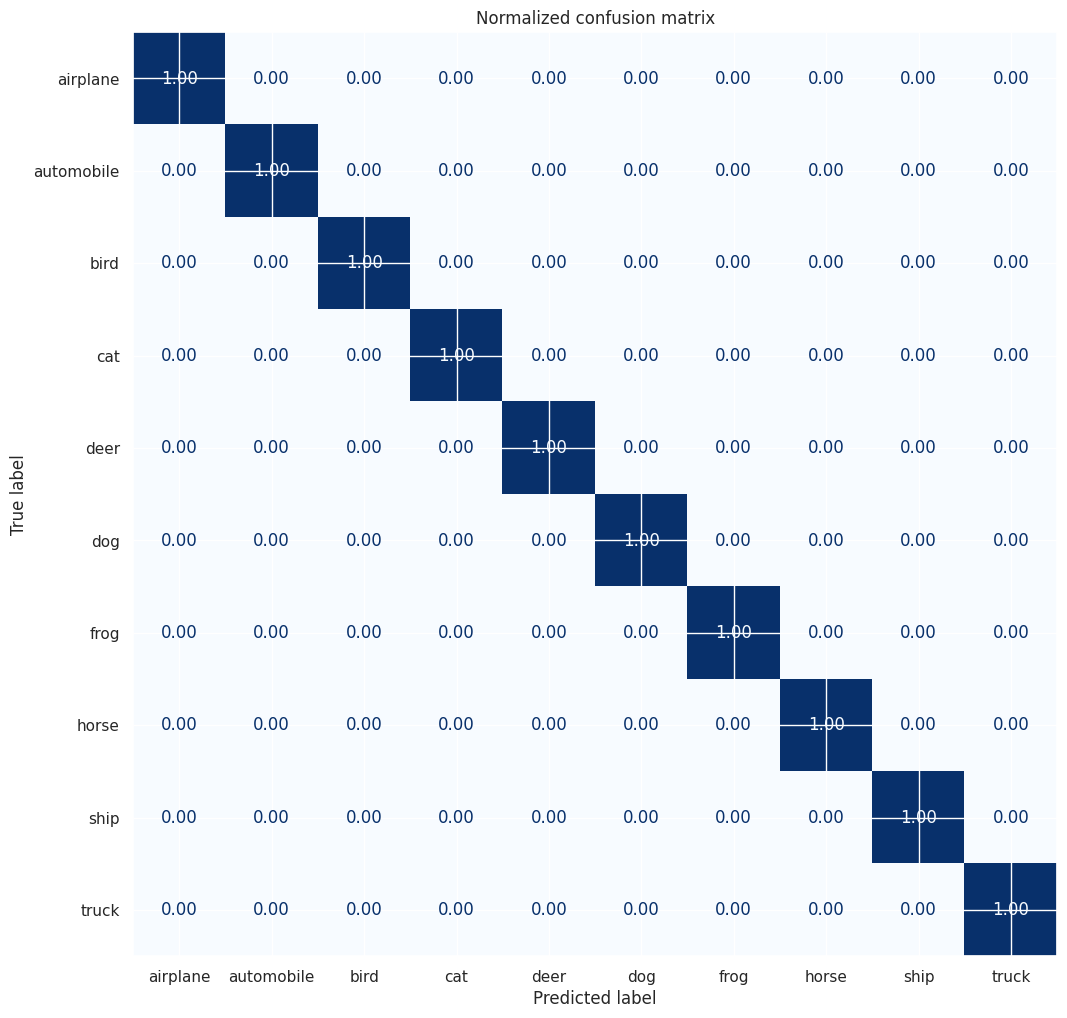

In [66]:
plot_confusion_matrix(train_prob, train_label, labels)

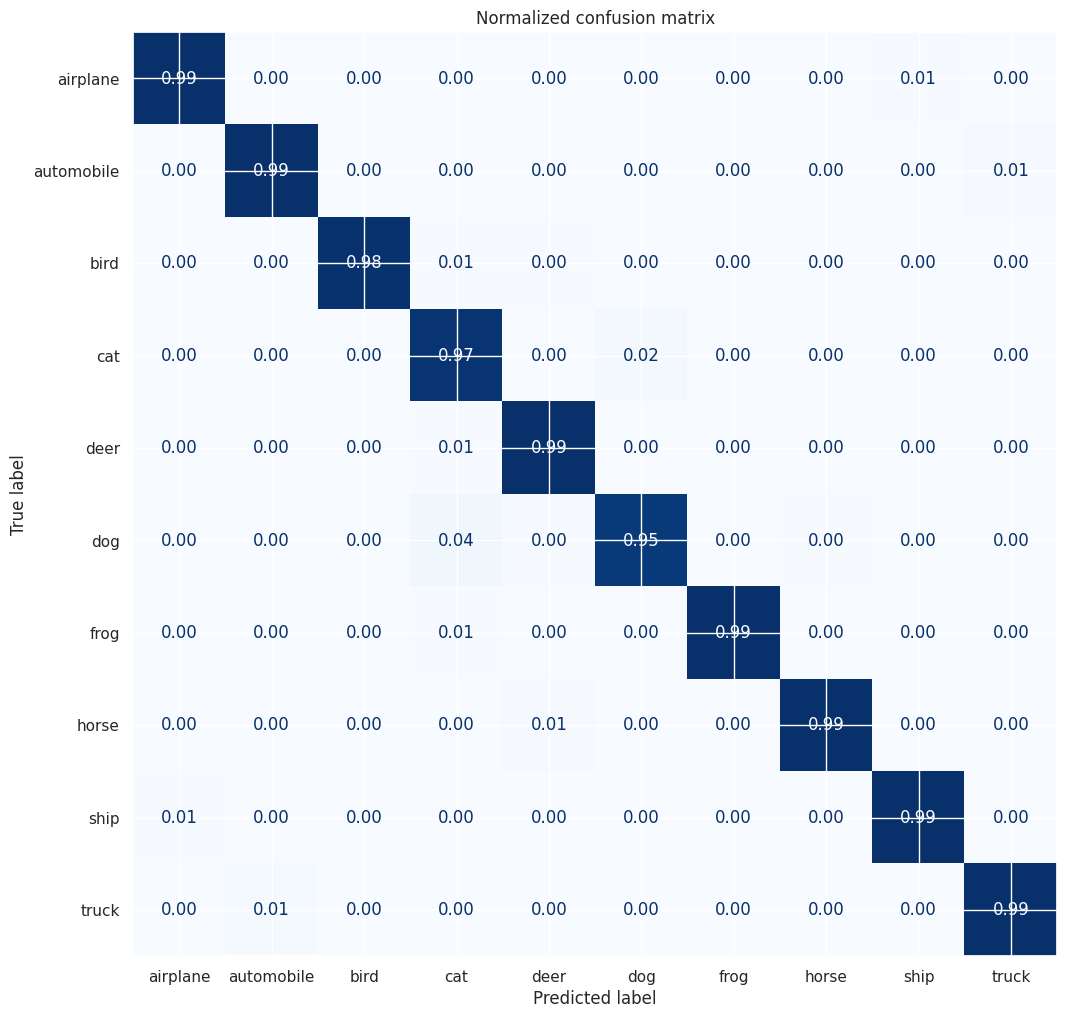

In [67]:
plot_confusion_matrix(test_prob, test_label, labels)

In [70]:
train_pred.metrics

{'test_loss': 0.005070374347269535,
 'test_accuracy': {'accuracy': 0.99916},
 'test_f1': {'f1': 0.9991599698695797},
 'test_runtime': 1968.5808,
 'test_samples_per_second': 25.399,
 'test_steps_per_second': 0.397}

In [71]:
test_pred.metrics

{'test_loss': 0.05960104987025261,
 'test_accuracy': {'accuracy': 0.9829},
 'test_f1': {'f1': 0.9829188809430107},
 'test_runtime': 392.0372,
 'test_samples_per_second': 25.508,
 'test_steps_per_second': 0.4}